In [1]:
!git clone https://github.com/NVlabs/stylegan.git
%cd stylegan

Cloning into 'stylegan'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.
/content/stylegan


In [0]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

url_ffhq        = 'https://drive.google.com/uc?id=1BO-e0hMUo5phBv_y_6jN4BDhkEiARV4X' # karras2019stylegan-ffhq-1024x1024.pkl
url_celebahq    = 'https://drive.google.com/uc?id=18LSTLKbyM4_NJaQKDejZ1hSO_eigV8-w' # karras2019stylegan-celebahq-1024x1024.pkl
url_bedrooms    = 'https://drive.google.com/uc?id=18z6Z_aq0LH4RE5rYBW6xZToSv5kAiKMS' # karras2019stylegan-bedrooms-256x256.pkl
url_cars        = 'https://drive.google.com/uc?id=1GaFpuWGyURTE48kZia4eQL23jJ56VDjC' # karras2019stylegan-cars-512x384.pkl
url_cats        = 'https://drive.google.com/uc?id=1xmnPEKDHpoJ1CHH_ACQhEoha3zuAJ_PZ' # karras2019stylegan-cats-256x256.pkl

In [0]:
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

_Gs_cache = dict()

def load_Gs(url):
    if url not in _Gs_cache:
        with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
            _G, _D, Gs = pickle.load(f)
        _Gs_cache[url] = Gs
    return _Gs_cache[url]
def draw_style_mixing_figure(png, Gs, w, h, src_seeds, dst_seeds, style_ranges):
    print(png)
    src_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in src_seeds)
    dst_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in dst_seeds)
    src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_seeds) + 1), h * (len(dst_seeds) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_seeds))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)

tflib.init_tf()
os.makedirs(config.result_dir, exist_ok=True)

Instructions for updating:
Colocations handled automatically by placer.


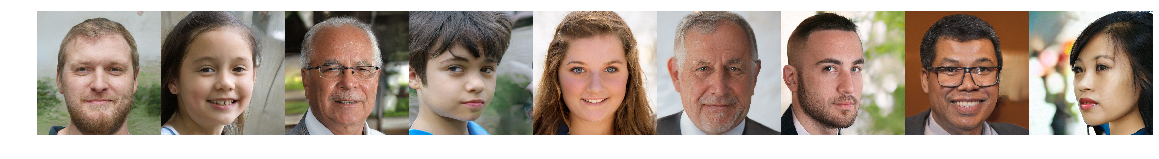

In [4]:
myGs = load_Gs(url_ffhq)
my_seeds=[918, 903, 183, 2222, 5634, 500, 204, 4304, 4303]
my_w=1024
my_h=1024
my_latents = np.stack(np.random.RandomState(seed).randn(myGs.input_shape[1]) for seed in my_seeds)
my_dlatents = myGs.components.mapping.run(my_latents, None) # [seed, layer, component]
my_images = myGs.components.synthesis.run(my_dlatents, randomize_noise=False, **synthesis_kwargs)
canvas = PIL.Image.new('RGB', (my_w * (len(my_seeds)), my_h * (0 + 1)), 'white')
for col, my_image in enumerate(list(my_images)):
    canvas.paste(PIL.Image.fromarray(my_image, 'RGB'), ((col) * my_w, 0))
canvas.save(os.path.join(config.result_dir, 'seeds.png'))
img=mpimg.imread('results/seeds.png')
plt.figure(figsize = (20,20))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

results/mixture.png


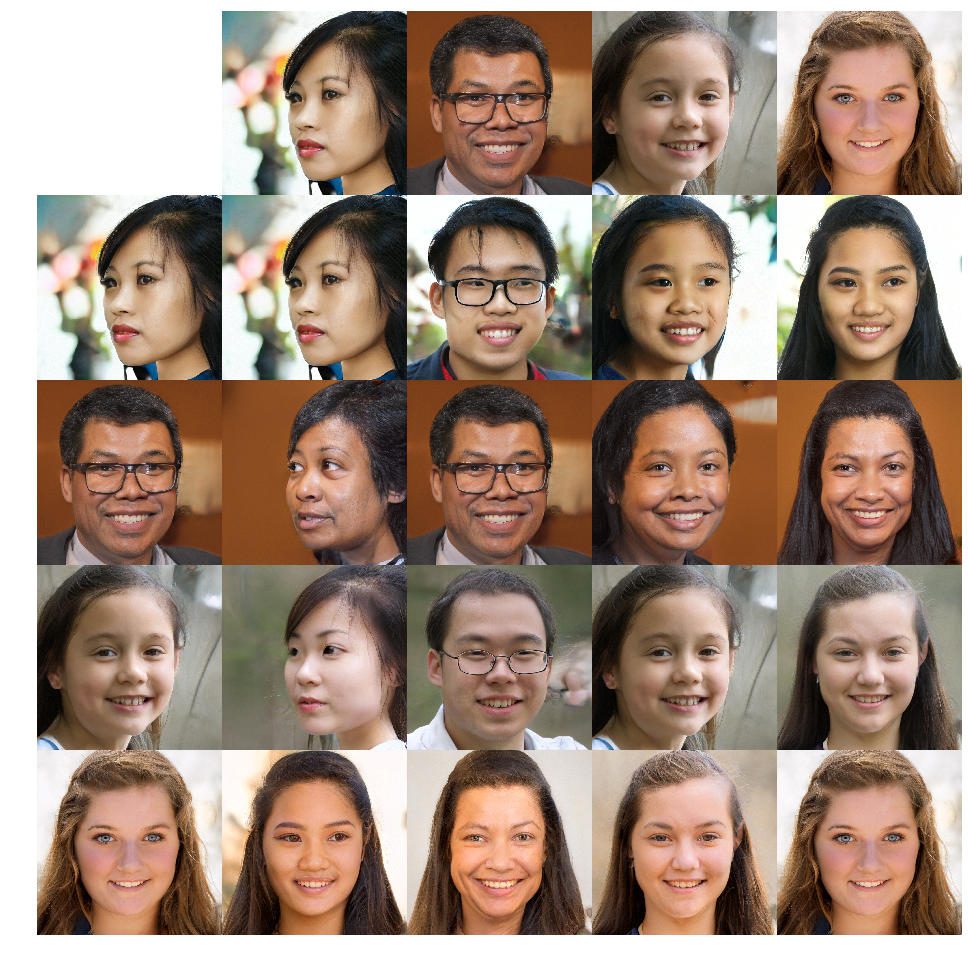

In [5]:
draw_style_mixing_figure(os.path.join(config.result_dir, 'mixture.png'), load_Gs(url_ffhq), w=1024, h=1024, src_seeds=[4303, 4304, 903, 5634], dst_seeds=[4303, 4304, 903, 5634], style_ranges=[range(0,4)]*3+[range(4,8)]*2+[range(8,18)])
img=mpimg.imread('results/mixture.png')
plt.figure(figsize = (17,17))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()